In [3275]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

In [3276]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [3277]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Loading Dataset
# Dataset link: https://data.mendeley.com/datasets/xvyv59vwvz/1
# Dataset is present in the current directory containing the code file.
df=pd.read_csv('ClaMP_Integrated-5184.csv')

## Preprocessing

In [3278]:
df.head()

,e_cblp,e_cp,e_cparhdr,e_maxalloc,e_sp,e_lfanew,NumberOfSections,CreationYear,FH_char0,FH_char1,FH_char2,FH_char3,FH_char4,FH_char5,FH_char6,FH_char7,FH_char8,FH_char9,FH_char10,FH_char11,FH_char12,FH_char13,FH_char14,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,OH_DLLchar0,OH_DLLchar1,OH_DLLchar2,OH_DLLchar3,OH_DLLchar4,OH_DLLchar5,OH_DLLchar6,OH_DLLchar7,OH_DLLchar8,OH_DLLchar9,OH_DLLchar10,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,sus_sections,non_sus_sections,packer,packer_type,E_text,E_data,filesize,E_file,fileinfo,class
0,144,3,4,65535,184,256,4,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,8,0,1100288,225792,0,1069880,4096,1110016,0,1,1,4,0,0,0,5,1,1,1,1194954,3,1,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,NoPacker,6.603616,5.443362,1181520,6.627552,1,0
1,144,3,4,65535,184,184,4,1,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,5,10,4096,2560,0,7680,4096,8192,1,1,1,4,0,0,0,4,0,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,NoPacker,5.205926,2.123522,7680,5.318221,0,0
2,144,3,4,65535,184,272,5,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,27648,20480,0,28859,4096,32768,1,1,1,5,0,0,0,5,0,1,1,67688,2,1,0,1,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,4,0,NoPacker,6.238000,3.380859,57872,6.507758,1,0
3,144,3,4,65535,184,184,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,0,87552,0,0,4096,4096,1,1,1,6,1,6,1,5,0,1,1,113668,2,1,0,1,0,1,0,0,0,0,0,0,1048576,4096,1048576,4096,1,0,1,0,NoPacker,0.000000,0.000000,95616,4.575092,1,0
4,144,3,4,65535,184,224,5,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,10,10,11776,36352,0,13379,4096,16384,1,1,1,6,2,6,2,6,2,1,1,69089,2,1,0,1,0,0,0,0,1,0,0,0,262144,8192,1048576,4096,1,1,4,0,NoPacker,6.355626,0.702621,48128,5.545531,1,0


In [3279]:
# Replacing Null values with 0. ML classifer cannot learn on Null values
df.fillna(0, inplace=True)

In [3280]:
# Peak on dataset
df.head()

,e_cblp,e_cp,e_cparhdr,e_maxalloc,e_sp,e_lfanew,NumberOfSections,CreationYear,FH_char0,FH_char1,FH_char2,FH_char3,FH_char4,FH_char5,FH_char6,FH_char7,FH_char8,FH_char9,FH_char10,FH_char11,FH_char12,FH_char13,FH_char14,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,OH_DLLchar0,OH_DLLchar1,OH_DLLchar2,OH_DLLchar3,OH_DLLchar4,OH_DLLchar5,OH_DLLchar6,OH_DLLchar7,OH_DLLchar8,OH_DLLchar9,OH_DLLchar10,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,sus_sections,non_sus_sections,packer,packer_type,E_text,E_data,filesize,E_file,fileinfo,class
0,144,3,4,65535,184,256,4,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,8,0,1100288,225792,0,1069880,4096,1110016,0,1,1,4,0,0,0,5,1,1,1,1194954,3,1,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,NoPacker,6.603616,5.443362,1181520,6.627552,1,0
1,144,3,4,65535,184,184,4,1,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,5,10,4096,2560,0,7680,4096,8192,1,1,1,4,0,0,0,4,0,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,NoPacker,5.205926,2.123522,7680,5.318221,0,0
2,144,3,4,65535,184,272,5,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,27648,20480,0,28859,4096,32768,1,1,1,5,0,0,0,5,0,1,1,67688,2,1,0,1,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,4,0,NoPacker,6.238000,3.380859,57872,6.507758,1,0
3,144,3,4,65535,184,184,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,0,87552,0,0,4096,4096,1,1,1,6,1,6,1,5,0,1,1,113668,2,1,0,1,0,1,0,0,0,0,0,0,1048576,4096,1048576,4096,1,0,1,0,NoPacker,0.000000,0.000000,95616,4.575092,1,0
4,144,3,4,65535,184,224,5,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,10,10,11776,36352,0,13379,4096,16384,1,1,1,6,2,6,2,6,2,1,1,69089,2,1,0,1,0,0,0,0,1,0,0,0,262144,8192,1048576,4096,1,1,4,0,NoPacker,6.355626,0.702621,48128,5.545531,1,0


In [3281]:
# Droping these columns due to their insignificance
df=df.drop(['NumberOfSections','CreationYear','e_cblp','e_cp','e_cparhdr','e_maxalloc'], axis=1)

In [3282]:
df.shape

(5210, 64)

In [3283]:
# Peak on the dataset
df.head()

,e_sp,e_lfanew,FH_char0,FH_char1,FH_char2,FH_char3,FH_char4,FH_char5,FH_char6,FH_char7,FH_char8,FH_char9,FH_char10,FH_char11,FH_char12,FH_char13,FH_char14,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,OH_DLLchar0,OH_DLLchar1,OH_DLLchar2,OH_DLLchar3,OH_DLLchar4,OH_DLLchar5,OH_DLLchar6,OH_DLLchar7,OH_DLLchar8,OH_DLLchar9,OH_DLLchar10,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,sus_sections,non_sus_sections,packer,packer_type,E_text,E_data,filesize,E_file,fileinfo,class
0,184,256,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,8,0,1100288,225792,0,1069880,4096,1110016,0,1,1,4,0,0,0,5,1,1,1,1194954,3,1,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,NoPacker,6.603616,5.443362,1181520,6.627552,1,0
1,184,184,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,5,10,4096,2560,0,7680,4096,8192,1,1,1,4,0,0,0,4,0,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,NoPacker,5.205926,2.123522,7680,5.318221,0,0
2,184,272,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,27648,20480,0,28859,4096,32768,1,1,1,5,0,0,0,5,0,1,1,67688,2,1,0,1,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,4,0,NoPacker,6.238000,3.380859,57872,6.507758,1,0
3,184,184,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,0,87552,0,0,4096,4096,1,1,1,6,1,6,1,5,0,1,1,113668,2,1,0,1,0,1,0,0,0,0,0,0,1048576,4096,1048576,4096,1,0,1,0,NoPacker,0.000000,0.000000,95616,4.575092,1,0
4,184,224,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,10,10,11776,36352,0,13379,4096,16384,1,1,1,6,2,6,2,6,2,1,1,69089,2,1,0,1,0,0,0,0,1,0,0,0,262144,8192,1048576,4096,1,1,4,0,NoPacker,6.355626,0.702621,48128,5.545531,1,0


In [3284]:
yes,no = df['class'].value_counts()

In [3285]:
print(yes,no)

2722 2488


In [3286]:
#No class has less instances

In [3287]:
# Encodings Labels so that they are compatible with machine leanring classifiers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in df:
    if df[i].dtype=='object':
        df[i] = le.fit_transform(df[i])
    else:
        continue
X = df.drop(['class'],axis=1)
y = df['class']

In [3288]:
# Now check the features for the feature column "Packer_type". They are converted fr
df.head()

,e_sp,e_lfanew,FH_char0,FH_char1,FH_char2,FH_char3,FH_char4,FH_char5,FH_char6,FH_char7,FH_char8,FH_char9,FH_char10,FH_char11,FH_char12,FH_char13,FH_char14,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,OH_DLLchar0,OH_DLLchar1,OH_DLLchar2,OH_DLLchar3,OH_DLLchar4,OH_DLLchar5,OH_DLLchar6,OH_DLLchar7,OH_DLLchar8,OH_DLLchar9,OH_DLLchar10,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,sus_sections,non_sus_sections,packer,packer_type,E_text,E_data,filesize,E_file,fileinfo,class
0,184,256,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,8,0,1100288,225792,0,1069880,4096,1110016,0,1,1,4,0,0,0,5,1,1,1,1194954,3,1,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,18,6.603616,5.443362,1181520,6.627552,1,0
1,184,184,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,5,10,4096,2560,0,7680,4096,8192,1,1,1,4,0,0,0,4,0,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,18,5.205926,2.123522,7680,5.318221,0,0
2,184,272,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,27648,20480,0,28859,4096,32768,1,1,1,5,0,0,0,5,0,1,1,67688,2,1,0,1,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,4,0,18,6.238000,3.380859,57872,6.507758,1,0
3,184,184,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,0,87552,0,0,4096,4096,1,1,1,6,1,6,1,5,0,1,1,113668,2,1,0,1,0,1,0,0,0,0,0,0,1048576,4096,1048576,4096,1,0,1,0,18,0.000000,0.000000,95616,4.575092,1,0
4,184,224,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,10,10,11776,36352,0,13379,4096,16384,1,1,1,6,2,6,2,6,2,1,1,69089,2,1,0,1,0,0,0,0,1,0,0,0,262144,8192,1048576,4096,1,1,4,0,18,6.355626,0.702621,48128,5.545531,1,0


In [3289]:
# Dividing data into training, testing and validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=1)

In [3290]:
# Scaling data. Default scaling is to scale the data to unit variance (or equivalent
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)
X_val = mms.transform(X_val)

X_val = torch.tensor(X_val, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
X_train = torch.tensor(X_train, dtype=torch.float)

## **CNN Wing 1**



In [3291]:
final_dims = 15
current_dims = len(df.columns)-1

In [3292]:
pt_x_train = torch.from_numpy(np.array(X_train)).to(torch.float)
pt_y_train = torch.from_numpy(np.array(y_train)).to(torch.float)
pt_train = TensorDataset(pt_x_train, pt_y_train)
pt_train = DataLoader(pt_train, batch_size=64)

In [3293]:
class CNN1(nn.Module):
  def __init__(self):
    super(CNN1, self).__init__()
    self.cnn = nn.Sequential(
        nn.Conv1d(1,3,kernel_size = (1,4), stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(3),
        nn.Conv1d(3,3,kernel_size = (1,4), stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(3),
        nn.Conv1d(3,3,kernel_size = (1,4), stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(3),
        nn.Flatten(),
        nn.Linear(162, 15),
        nn.ReLU()
    )

    self.clf = nn.Sequential(
        nn.Linear(15,1),
        nn.Sigmoid()
    )

  def forward(self, x):
    features = self.cnn(x)
    return self.clf(features)

  def transform(self, x):
    return self.cnn(x)

In [3294]:
cnn = CNN1()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr = 4e-4)

In [3295]:
num_epochs = 100
outputs = []
losses = []
for epoch in range(num_epochs):
  for instance, y in pt_train:
    output = cnn(instance.view(-1,1,1,63))
    loss = criterion(output.view(-1,1), y.view(-1,1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  losses.append(loss.item())
  print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')

Epoch:1, Loss:0.4771
Epoch:2, Loss:0.3555
Epoch:3, Loss:0.3009
Epoch:4, Loss:0.2745
Epoch:5, Loss:0.2612
Epoch:6, Loss:0.2525
Epoch:7, Loss:0.2481
Epoch:8, Loss:0.2437
Epoch:9, Loss:0.2393
Epoch:10, Loss:0.2354
Epoch:11, Loss:0.2300
Epoch:12, Loss:0.2265
Epoch:13, Loss:0.2244
Epoch:14, Loss:0.2206
Epoch:15, Loss:0.2189
Epoch:16, Loss:0.2156
Epoch:17, Loss:0.2177
Epoch:18, Loss:0.2190
Epoch:19, Loss:0.2131
Epoch:20, Loss:0.2132
Epoch:21, Loss:0.2067
Epoch:22, Loss:0.2070
Epoch:23, Loss:0.2033
Epoch:24, Loss:0.2013
Epoch:25, Loss:0.2005
Epoch:26, Loss:0.1934
Epoch:27, Loss:0.1876
Epoch:28, Loss:0.1893
Epoch:29, Loss:0.1942
Epoch:30, Loss:0.1916
Epoch:31, Loss:0.1900
Epoch:32, Loss:0.1898
Epoch:33, Loss:0.1932
Epoch:34, Loss:0.1872
Epoch:35, Loss:0.1885
Epoch:36, Loss:0.1904
Epoch:37, Loss:0.1889
Epoch:38, Loss:0.1857
Epoch:39, Loss:0.1877
Epoch:40, Loss:0.1891
Epoch:41, Loss:0.1854
Epoch:42, Loss:0.1849
Epoch:43, Loss:0.1784
Epoch:44, Loss:0.1796
Epoch:45, Loss:0.1785
Epoch:46, Loss:0.17

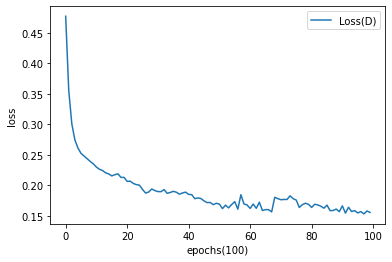

In [3296]:
plt.plot(losses)
plt.xlabel(f"epochs({num_epochs})")
plt.ylabel(f"loss")
_ = plt.legend(['Loss(D)'])

In [3297]:
cnn.eval()
with torch.no_grad():
  encoded_train_X = cnn.transform(X_train.view(-1,1,1,63)).view(-1,15)
  encoded_test_X = cnn.transform(X_test.view(-1,1,1,63)).view(-1,15)

In [3298]:
encoded_train_X.size(), encoded_test_X.size()

(torch.Size([3711, 15]), torch.Size([1303, 15]))

In [3299]:
X_train = encoded_train_X.detach().numpy()
X_test = encoded_test_X.detach().numpy()

## MLP Classifier on encoded data

In [3300]:
from sklearn.neural_network import MLPClassifier

#LBFGS is the optimizer, which works relatively better when applied on 
#smaller datasets because it's a local search algorithm
clf = MLPClassifier(solver='adam', alpha=1e-5,
                    hidden_layer_sizes=(5,2), random_state=1)

clf.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1)

In [3301]:
y_pred = clf.predict(X_test)
lr_probs = clf.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

In [3302]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
tn=cm[0][0] #tn
fn=cm[0][1] #fn
fp=cm[1][0] #fp
tp=cm[1][1] #tp
acc= (tp+tn)/(tp+tn+fn+fp)
epsilon = 1e-7 # is used so that to avoid divide by zero error
precision = tp / (tp + fp + epsilon)
recall = tp / (tp + fn + epsilon)
sensitivity,specificity = tp/(tp+fn),tn/(tn+fp)
print("Test accuracy is:"+str(format(acc,'.4f')))
print("Precision: "+str(format(precision,'.4f'))+" Recall: "+str(format(recall,'.4f')))

Test accuracy is:0.9593
Precision: 0.9730 Recall: 0.9488


In [3303]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print('Average CV Score: ',scores.mean())
scores

Average CV Score:  0.9760183999448582


array([0.9717362 , 0.97574124, 0.97843666, 0.97304582, 0.98113208])

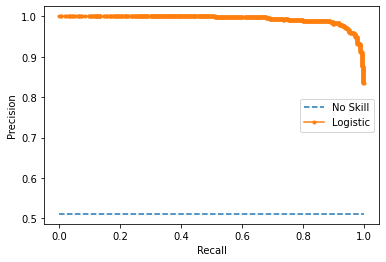

F1: 0.960711638250556
AUC: 0.9931299476408192
Accuracy 0.9593246354566385


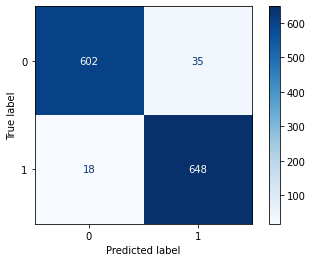

In [3304]:
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
no_skill = len(y_test[y_test==1]) / len(y_test)
acc = accuracy_score(y_test, y_pred)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

print("F1:",lr_f1)
print("AUC:",lr_auc)
print("Accuracy",acc)

_ = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap="Blues")

In [3305]:
torch.save(encoder.state_dict(), 'cnn1.pt')